In [1]:
!bash ./download_data.sh

--2021-09-03 16:23:25--  http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip [following]
--2021-09-03 16:23:25--  https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6372817 (6.1M) [application/zip]
Saving to: ‘stanfordSentimentTreebank.zip’

stanfordSentimentTr 100%[===================>]   6.08M  11.3MB/s    in 0.5s    

2021-09-03 16:23:26 (11.3 MB/s) - ‘stanfordSentimentTreebank.zip’ saved [6372817/6372817]

Archive:  stanfordSentimentTreebank.zip
   creating: stanfordSentimentTreebank/
  inflating: stanfordSentimentTreebank/datasetSentences.txt  
   creating: 

# Задание 5.1 - Word2Vec

В этом задании мы натренируем свои word vectors на очень небольшом датасете.
Мы будем использовать самую простую версию word2vec, без negative sampling и других оптимизаций.

Перед запуском нужно запустить скрипт `download_data.sh` чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA 
from tqdm import tqdm

%matplotlib inline

device = torch.device("cuda:0")

In [4]:
import os
import numpy as np

class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {}
        self.token_by_index = []

        self.sentences = []

        self.token_freq = {}
        
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        # Following sampling strategy from word2vec paper:
        # https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
        
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
diapers ['changing', "'s"]
40 ['years', 'ago']
ardently ['problem', 'storylines', 'question']
evaluate ['makes', 're-assess', 'truly', 'ours']
huston ['both', 'glad-handing']


# Имплеменируем PyTorch-style Dataset для Word2Vec

Этот Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Напоминаем, что word2vec модель получает на вход One-hot вектор слова и тренирует простую сеть для предсказания на его основе соседних слов.
Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте):

Например:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `love`
- input: `orders`, target: `nicest`
- input: `orders`, target: `to`
- input: `orders`, target: `50-year`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [5]:
class Word2VecPlain(Dataset):
    '''
    PyTorch Dataset for plain Word2Vec.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data: StanfordTreeBank, num_contexts=30000):
        '''
        Initializes Word2VecPlain, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instace
        num_contexts - number of random contexts to use when generating a dataset
        '''
        self.data = data
        self.num_contexts = num_contexts
        
    
    def generate_dataset(self):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        self.samples = []
        for _ in range(self.num_contexts):
            center_word, other_words = data.get_random_context(5)
            self.samples.extend([(center_word, other) for other in other_words])
            
        
    def __len__(self):
        '''
        Returns total number of samples
        '''
        return len(self.samples)
    
    def __getitem__(self, index):
        '''
        Returns i-th sample
        
        Return values:
        input_vector - torch.Tensor with one-hot representation of the input vector
        output_index - index of the target word (not torch.Tensor!)
        '''
        input_vector = torch.zeros(self.data.num_tokens())
        input_vector[self.data.index_by_token[self.samples[index][0]]] = 1
            
        output_index = self.data.index_by_token[self.samples[index][1]]

        return input_vector, output_index


dataset = Word2VecPlain(data, 10)
dataset.generate_dataset()
input_vector, target = dataset[3]
print("Sample - input: %s, target: %s" % (input_vector, int(target))) # target should be able to convert to int
assert isinstance(input_vector, torch.Tensor)
assert torch.sum(input_vector) == 1.0
assert input_vector.shape[0] == data.num_tokens()

Sample - input: tensor([0., 0., 0.,  ..., 0., 0., 0.]), target: 7395


# Создаём и тренируем модель

In [74]:
# Create the usual PyTorch structures
dataset = Word2VecPlain(data, 30000)
dataset.generate_dataset()

# We'll be training very small word vectors!
wordvec_dim = 10

# We can use a standard sequential model for this
nn_model = nn.Sequential(
            nn.Linear(data.num_tokens(), wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, data.num_tokens(), bias=False), 
         )
nn_model.type(torch.FloatTensor)
nn_model.to(device)

Sequential(
  (0): Linear(in_features=19538, out_features=10, bias=False)
  (1): Linear(in_features=10, out_features=19538, bias=False)
)

In [72]:
def extract_word_vectors(nn_model):
    '''
    Extracts word vectors from the model
    
    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    layers = [module.weight for module in nn_model.modules() if not isinstance(module, nn.Sequential)]
    layers[0] = layers[0].T
    return tuple(layers)


untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [43]:
def train_model(model, dataset, train_loader, optimizer, scheduler, num_epochs):
    '''
    Trains plain word2vec using cross-entropy loss and regenerating dataset every epoch
    
    Returns:
    loss_history, train_history
    '''
    
    loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
    
    loss_history = []
    train_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        dataset.generate_dataset() # Regenerate dataset every epoch
        
        for i_step, (x, y) in enumerate(tqdm(train_loader)):
            x_gpu = x.to(device)
            y_gpu = y.to(device)

            optimizer.zero_grad()

            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
           
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y_gpu.shape[0]

            loss_accum += loss_value
        
        scheduler.step()

        ave_loss = loss_accum / len(train_loader)
        train_accuracy = float(correct_samples) / total_samples
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)

        print("Epoch %i, Average loss: %f, Train accuracy: %f" % (epoch, ave_loss, train_accuracy))
        
    return loss_history, train_history

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **8.0**.

In [75]:
# Finally, let's train the model!

# TODO: We use placeholder values for hyperparameters - you will need to find better values!
optimizer = optim.Adam(nn_model.parameters(), lr=1e-2, weight_decay=1e-7)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=256)

loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 40)

100%|██████████| 323/323 [00:05<00:00, 59.65it/s]


Epoch 0, Average loss: 9.814122, Train accuracy: 0.001246


100%|██████████| 325/325 [00:05<00:00, 58.19it/s]


Epoch 1, Average loss: 9.666806, Train accuracy: 0.002358


100%|██████████| 324/324 [00:05<00:00, 54.56it/s]


Epoch 2, Average loss: 9.536673, Train accuracy: 0.002680


100%|██████████| 323/323 [00:05<00:00, 57.13it/s]


Epoch 3, Average loss: 9.417425, Train accuracy: 0.003571


100%|██████████| 323/323 [00:05<00:00, 55.92it/s]


Epoch 4, Average loss: 9.311063, Train accuracy: 0.005117


100%|██████████| 323/323 [00:05<00:00, 56.04it/s]


Epoch 5, Average loss: 9.203856, Train accuracy: 0.006310


100%|██████████| 323/323 [00:05<00:00, 56.47it/s]


Epoch 6, Average loss: 9.089338, Train accuracy: 0.008347


100%|██████████| 324/324 [00:05<00:00, 55.41it/s]


Epoch 7, Average loss: 8.968408, Train accuracy: 0.010696


100%|██████████| 324/324 [00:05<00:00, 56.50it/s]


Epoch 8, Average loss: 8.867354, Train accuracy: 0.012978


100%|██████████| 324/324 [00:05<00:00, 55.10it/s]


Epoch 9, Average loss: 8.787929, Train accuracy: 0.015320


100%|██████████| 324/324 [00:05<00:00, 56.50it/s]


Epoch 10, Average loss: 8.686206, Train accuracy: 0.018191


100%|██████████| 324/324 [00:05<00:00, 58.59it/s]


Epoch 11, Average loss: 8.607765, Train accuracy: 0.019357


100%|██████████| 324/324 [00:05<00:00, 58.86it/s]


Epoch 12, Average loss: 8.536989, Train accuracy: 0.020428


100%|██████████| 323/323 [00:05<00:00, 57.04it/s]


Epoch 13, Average loss: 8.476319, Train accuracy: 0.021983


100%|██████████| 323/323 [00:05<00:00, 56.83it/s]


Epoch 14, Average loss: 8.406105, Train accuracy: 0.023306


100%|██████████| 324/324 [00:05<00:00, 60.70it/s]


Epoch 15, Average loss: 8.376289, Train accuracy: 0.024870


100%|██████████| 324/324 [00:05<00:00, 56.86it/s]


Epoch 16, Average loss: 8.319557, Train accuracy: 0.025799


100%|██████████| 324/324 [00:05<00:00, 55.33it/s]


Epoch 17, Average loss: 8.294120, Train accuracy: 0.027004


100%|██████████| 324/324 [00:05<00:00, 55.91it/s]


Epoch 18, Average loss: 8.229459, Train accuracy: 0.029373


100%|██████████| 323/323 [00:05<00:00, 56.16it/s]


Epoch 19, Average loss: 8.201885, Train accuracy: 0.028885


100%|██████████| 324/324 [00:05<00:00, 56.32it/s]


Epoch 20, Average loss: 8.171515, Train accuracy: 0.030429


100%|██████████| 324/324 [00:05<00:00, 54.67it/s]


Epoch 21, Average loss: 8.127999, Train accuracy: 0.031033


100%|██████████| 324/324 [00:05<00:00, 55.48it/s]


Epoch 22, Average loss: 8.099727, Train accuracy: 0.033167


100%|██████████| 323/323 [00:05<00:00, 55.31it/s]


Epoch 23, Average loss: 8.063141, Train accuracy: 0.032386


100%|██████████| 324/324 [00:05<00:00, 55.77it/s]


Epoch 24, Average loss: 8.036433, Train accuracy: 0.033766


100%|██████████| 323/323 [00:05<00:00, 56.54it/s]


Epoch 25, Average loss: 8.039768, Train accuracy: 0.033318


100%|██████████| 324/324 [00:05<00:00, 54.39it/s]


Epoch 26, Average loss: 8.008753, Train accuracy: 0.033706


100%|██████████| 324/324 [00:05<00:00, 56.63it/s]


Epoch 27, Average loss: 7.991233, Train accuracy: 0.035003


100%|██████████| 324/324 [00:05<00:00, 55.20it/s]


Epoch 28, Average loss: 7.973099, Train accuracy: 0.035877


100%|██████████| 324/324 [00:05<00:00, 55.57it/s]


Epoch 29, Average loss: 7.983081, Train accuracy: 0.034754


100%|██████████| 324/324 [00:05<00:00, 55.65it/s]


Epoch 30, Average loss: 7.956211, Train accuracy: 0.034674


100%|██████████| 324/324 [00:06<00:00, 51.96it/s]


Epoch 31, Average loss: 7.925842, Train accuracy: 0.036488


100%|██████████| 323/323 [00:05<00:00, 55.36it/s]


Epoch 32, Average loss: 7.904452, Train accuracy: 0.038091


100%|██████████| 324/324 [00:05<00:00, 54.48it/s]


Epoch 33, Average loss: 7.867120, Train accuracy: 0.037897


100%|██████████| 324/324 [00:05<00:00, 55.40it/s]


Epoch 34, Average loss: 7.867844, Train accuracy: 0.037068


100%|██████████| 325/325 [00:05<00:00, 56.24it/s]


Epoch 35, Average loss: 7.874569, Train accuracy: 0.037427


100%|██████████| 325/325 [00:05<00:00, 54.83it/s]


Epoch 36, Average loss: 7.845303, Train accuracy: 0.037697


100%|██████████| 324/324 [00:05<00:00, 54.21it/s]


Epoch 37, Average loss: 7.855690, Train accuracy: 0.037856


100%|██████████| 324/324 [00:05<00:00, 56.00it/s]


Epoch 38, Average loss: 7.833484, Train accuracy: 0.037962


100%|██████████| 324/324 [00:05<00:00, 55.22it/s]

Epoch 39, Average loss: 7.819902, Train accuracy: 0.038304


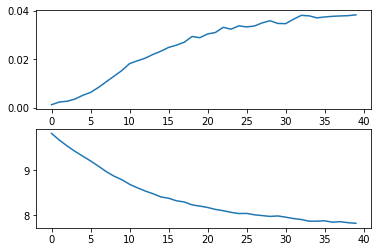

In [76]:
# Visualize training graphs
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history)

# Визуализируем вектора для разного вида слов до и после тренировки

В случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных) разделяются семантически.

Студенты - в качестве выполненного задания присылайте notebook с диаграммами!

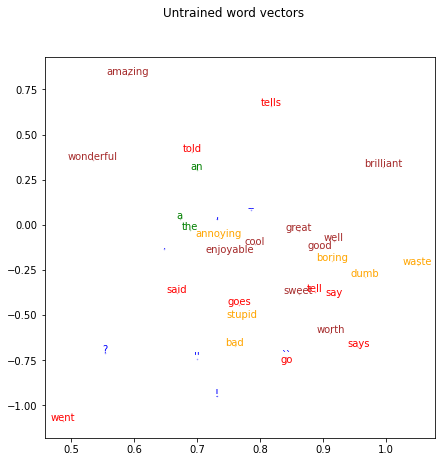

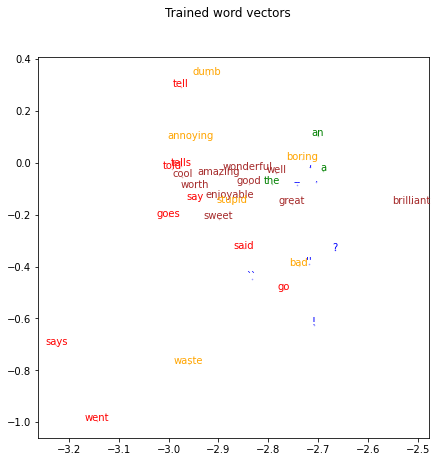

In [77]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors.to('cpu').detach(), 
                              output_vectors.to('cpu').detach()), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors)

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")